In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.cluster as cluster
import pickle
import GEMS
import itertools
import dill
import abc_etc
import evo_etc

In [3]:
# Convenient pickle wrappers
def load_pickle(filename):
    return dill.load(open(file=filename,mode='rb'))
        
def dump_pickle(obj,filename):
    return dill.dump(obj=obj,file=open(file=filename, mode='wb'))

In [4]:
# This solution is really ugly, but I cannot see another easy way to solve this problem
def simulator(candidate):
    # There is really nothing to similate in this toy example, so we just return the answer
    return candidate

def fitness_function(dummy,candidate):
    denomenator = 1+((candidate["x"]-1)**2+(candidate["y"]-1)**2)*((candidate["x"]+1)**2+(candidate["y"]+1)**2)
    R2 = 1/denomenator
    return -R2

def extract_bayesian_final_generation(model: abc_etc.SMCABC ,population_size=128):
    particles_to_pick = np.argsort(model.all_distances)[:population_size]
    return [model.all_particles[particle] for particle in particles_to_pick]

def extract_evolution_final_generation(model: evo_etc.CrowdingDE):
    particles_to_pick = model.population[-1]
    return [model.all_particles[particle] for particle in particles_to_pick]
    




outdir = "../results/toy_example"
n_simulations = 4
toy_example_results = pd.DataFrame(index=pd.MultiIndex.from_product([["Bayesian","Evolutionary"],range(n_simulations)],names=["Method","Simulation"])).reset_index()
toy_example_results["modelfile"] = list(itertools.starmap(lambda method,simulation: f"{'bayesian' if method == 'Bayesian' else 'crowdingDE'}_{simulation}.pkl",
                                                      toy_example_results[["Method","Simulation"]].itertuples(index=False,name=None)))
toy_example_results["model"] = list(map(lambda filename: load_pickle(f"{outdir}/{filename}"),toy_example_results["modelfile"]))
toy_example_results["final_generation"] = list(itertools.starmap(lambda method, model: (extract_bayesian_final_generation if method == "Bayesian" else extract_evolution_final_generation)(model),
                                              toy_example_results[["Method","model"]].itertuples(index=False,name=None)))
toy_example_results.set_index(["Method","Simulation"],inplace=True)


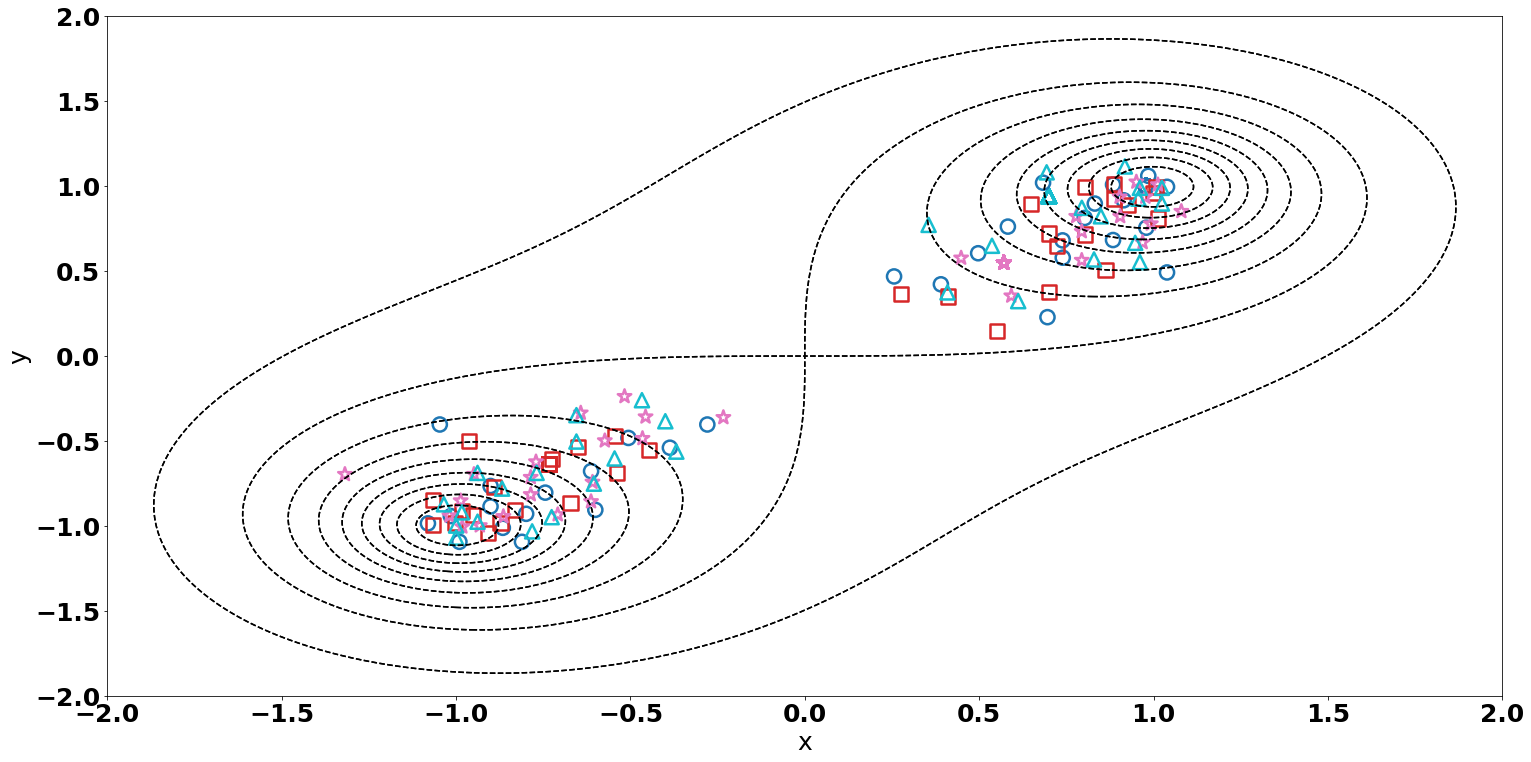

In [6]:
def contour_function(x,y):
    denomenator = 1+((x-1)**2+(y-1)**2)*((x+1)**2+(y+1)**2)
    R2 = 1/denomenator
    return -R2

plt.figure(figsize=(2*12.5,12.5))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 25}
matplotlib.rc('font', **font)
def plot_population(particles,simulation=0):
    cmap = matplotlib.cm.get_cmap('tab10',n_simulations)
    markers = ["o","s","*", "^"]
    x,y = zip(*[(particle["x"],particle["y"]) for particle in particles])
    plt.scatter(x,y,s=200,alpha=1,facecolors="none",edgecolors=cmap(simulation),marker=markers[simulation % 4],linewidths=2.5)
    plt.xlim((-2,2))
    plt.ylim((-2,2))
    plt.xlabel("x")
    plt.ylabel("y")


for i, method in enumerate(["Bayesian","Evolutionary"],start=0):
    X, Y = np.meshgrid(np.linspace(-2,2,1000),np.linspace(-2,2,1000))
    Z = contour_function(X,Y)
    plt.contour(X,Y,Z,10,colors="black")
    for j, simulation in enumerate(toy_example_results.loc[method].index):
        plot_population(toy_example_results.loc[(method,simulation),"final_generation"],j)
    plt.savefig(f"../figures/toy_{method}.png",dpi=300)
    

plt.show()


In [8]:
!pwd

/home/jakobpp/Dokumenter/OneDrive/CoolWine/etcFBA/BayesianGEM/code


In [ ]:
"../results/permuted_smcevo_res/"

In [9]:
model_skeleton = load_pickle("../results/permuted_smcabc_res/distance_frame.pkl")
model_frame = model_skeleton.set_index(["origin","status"])
reference_distances = model_frame.loc[("unpermuted","original"),"all_distances"]
distances = model_frame["all_distances"]

In [16]:
distances

origin      status   
unpermuted  original     [1.8806262337240804, 1.8384516977114769, -0.00...
            replicate    [1.8806262332115982, 1.8384516976521177, 0.090...
permuted_0  original     [1.8806262332115977, 1.8384516991098205, 0.090...
            replicate    [1.8806262332115982, 1.8384516990441486, -0.00...
permuted_1  original     [1.88062623349332, 1.838451699147032, 0.000929...
            replicate    [1.8806262332115995, 1.8384516976280514, 2.972...
permuted_2  original     [1.8806262329822265, 1.8384516991154645, -0.00...
            replicate    [1.8806262332115982, 1.838451697636416, 154911...
Name: all_distances, dtype: object

In [37]:
def plot_convergence_inner(distances, maxiter, offset = 128, generation_size = 100, ind_start = 0, label = None):
    # Offset: Number of newly generated particles per generation
    r2s = []
    ind = ind_start
    i = 0
    # This is a cleaver trick to avoid redoing calculations for every iterations which
    # turns out to be very time-consuming.
    r2s_history = -np.array(distances[:offset*maxiter])
    r2s_history_argsorted = np.argsort(r2s_history)
    while ind < len(distances):
        i += 1
        if i > maxiter:
            break
        # This is a mask ensuring data created after the interation are excluded
        filter_mask = r2s_history_argsorted < ind + offset
        r2s_now = r2s_history[r2s_history_argsorted[filter_mask]][-generation_size:]
        r2s.append(r2s_now)
        ind += offset
    y = np.array(r2s)
    yp = np.percentile(y,[5,50,95],axis=1)
    plt.plot(np.arange(len(r2s)),yp[1,:], label = label,linewidth=10)
    plt.fill_between(np.arange(len(r2s)),yp[0,:],yp[2,:],alpha=0.5)

In [38]:
model_frame

priors  \
origin     status                                                         
unpermuted original   {'O13525_Tm': <random_sampler.RV object at 0x7...   
           replicate  {'O13525_Tm': <random_sampler.RV object at 0x7...   
permuted_0 original   {'O13525_Tm': <random_sampler.RV object at 0x7...   
           replicate  {'O13525_Tm': <random_sampler.RV object at 0x7...   
permuted_1 original   {'O13525_Tm': <random_sampler.RV object at 0x7...   
           replicate  {'O13525_Tm': <random_sampler.RV object at 0x7...   
permuted_2 original   {'O13525_Tm': <random_sampler.RV object at 0x7...   
           replicate  {'O13525_Tm': <random_sampler.RV object at 0x7...   

                                                                outfile  \
origin     status                                                         
unpermuted original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   
permuted_0 original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   
permuted_1 original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   
permuted_2 original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   

                      random_seed  \
origin     status                   
unpermuted original         67639   
           replicate        89615   
permuted_0 original          7754   
           replicate        24427   
permuted_1 original         87989   
           replicate        77246   
permuted_2 original         87694   
           replicate        70728   

                                                          all_distances  
origin     status                                                        
unpermuted original   [1.8806262337240804, 1.8384516977114769, -0.00...  
           replicate  [1.8806262332115982, 1.8384516976521177, 0.090...  
permuted_0 original   [1.8806262332115977, 1.8384516991098205, 0.090...  
           replicate  [1.8806262332115982, 1.8384516990441486, -0.00...  
permuted_1 original   [1.88062623349332, 1.838451699147032, 0.000929...  
           replicate  [1.8806262332115995, 1.8384516976280514, 2.972...  
permuted_2 original   [1.8806262329822265, 1.8384516991154645, -0.00...  
           replicate  [1.8806262332115982, 1.838451697636416, 154911...

In [39]:
model_frame

priors  \
origin     status                                                         
unpermuted original   {'O13525_Tm': <random_sampler.RV object at 0x7...   
           replicate  {'O13525_Tm': <random_sampler.RV object at 0x7...   
permuted_0 original   {'O13525_Tm': <random_sampler.RV object at 0x7...   
           replicate  {'O13525_Tm': <random_sampler.RV object at 0x7...   
permuted_1 original   {'O13525_Tm': <random_sampler.RV object at 0x7...   
           replicate  {'O13525_Tm': <random_sampler.RV object at 0x7...   
permuted_2 original   {'O13525_Tm': <random_sampler.RV object at 0x7...   
           replicate  {'O13525_Tm': <random_sampler.RV object at 0x7...   

                                                                outfile  \
origin     status                                                         
unpermuted original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   
permuted_0 original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   
permuted_1 original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   
permuted_2 original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   

                      random_seed  \
origin     status                   
unpermuted original         67639   
           replicate        89615   
permuted_0 original          7754   
           replicate        24427   
permuted_1 original         87989   
           replicate        77246   
permuted_2 original         87694   
           replicate        70728   

                                                          all_distances  
origin     status                                                        
unpermuted original   [1.8806262337240804, 1.8384516977114769, -0.00...  
           replicate  [1.8806262332115982, 1.8384516976521177, 0.090...  
permuted_0 original   [1.8806262332115977, 1.8384516991098205, 0.090...  
           replicate  [1.8806262332115982, 1.8384516990441486, -0.00...  
permuted_1 original   [1.88062623349332, 1.838451699147032, 0.000929...  
           replicate  [1.8806262332115995, 1.8384516976280514, 2.972...  
permuted_2 original   [1.8806262329822265, 1.8384516991154645, -0.00...  
           replicate  [1.8806262332115982, 1.838451697636416, 154911...

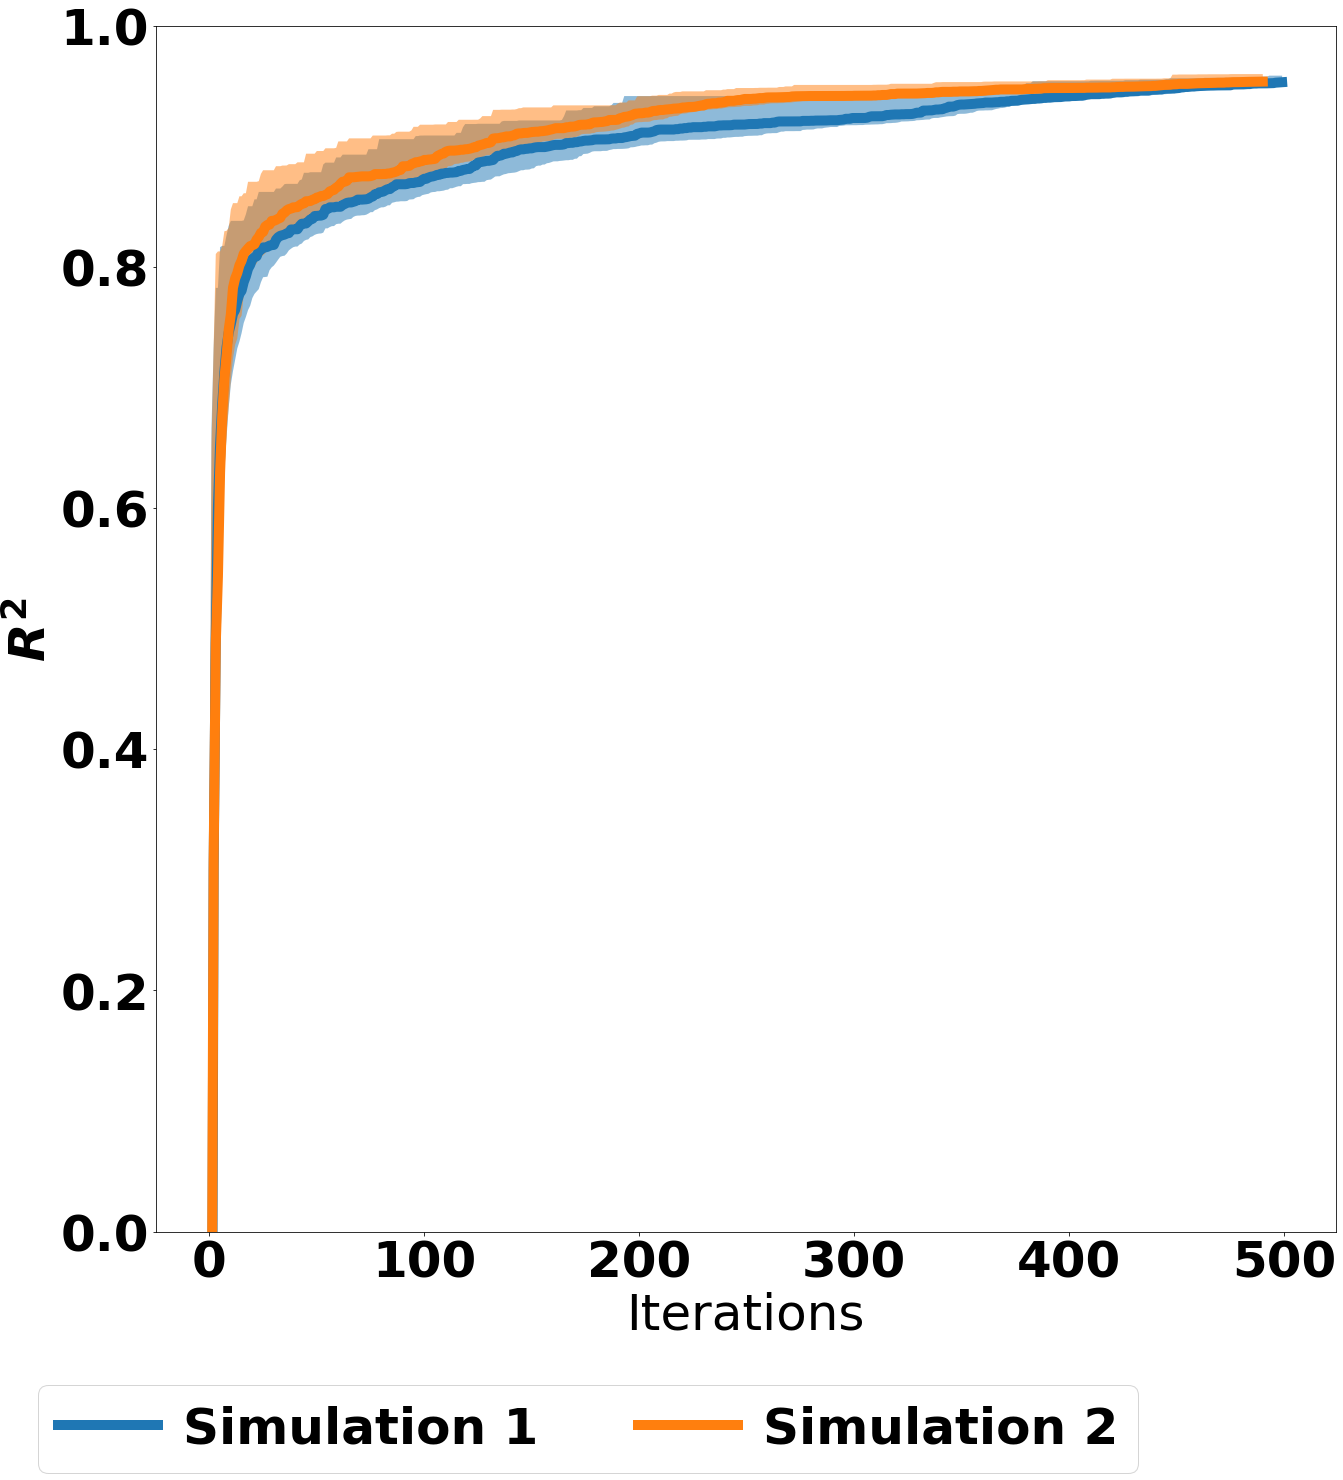

In [40]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 50}

matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
maxiter = 500
i = 1
plt.figure(figsize=(20,20))
# Simulation 1
original_distances = distances.loc[("unpermuted","original")]
# Simulation 2
replicate_distances = distances.loc[("unpermuted","replicate")]
plot_convergence_inner(original_distances,maxiter, label = 'Simulation 1')
plot_convergence_inner(replicate_distances,maxiter, label = 'Simulation 2')
plt.ylim([0,1])
plt.xlabel('Iterations')
plt.ylabel('$R^2$')
plt.tight_layout()
# plt.subplots_adjust(bottom=0.5,left=0.3)
plt.legend(loc=(-.1,-0.2),ncol=2,handletextpad=0.5)
# plt.savefig("../figures/R2.pdf")
plt.show()

In [41]:
combined_df_metadata = load_pickle("../results/permuted_smcabc_res/combined_df_metadata.pkl")
pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_full_ordination.pkl")

(63139,)
(61724,)


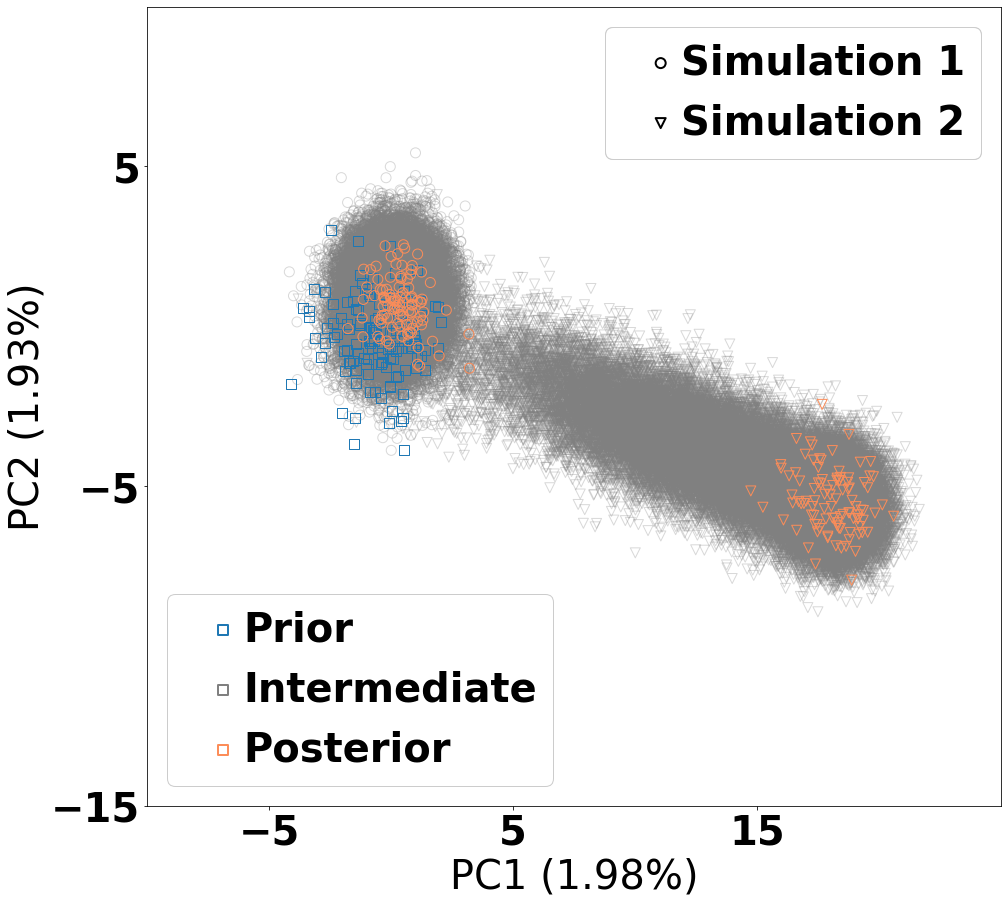

In [49]:
thinning_rng = np.random.default_rng(3052)
i=1
plt.figure(figsize=(15,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 40}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df_metadata["period"].to_numpy()
prior = combined_df_metadata["origin"].to_numpy()
model = combined_df_metadata["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
PCS, EV = pca_ordination
origin = "unpermuted"
for label in ['original', 'replicate']:
    label_idxs = np.nonzero((model == label) & (prior == origin))[0]
    marker = marker_dict[label]
    this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
    this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=min(len(this_idxs["Intermediate"]),100000),replace=False)
    this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=min(len(this_idxs["Posterior"]),100000),replace=False)
    print(label_idxs.shape)
    plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
    
for label in ['original', 'replicate']:
    label_idxs = np.nonzero((model == label) & (prior == origin))[0]
    marker = marker_dict[label]
    this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
    this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
    this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
    if label=="original":
        plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                    marker="s",facecolors='none',s=100)
    plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
i += 1
plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
plt.xticks(np.arange(-15,25,10))
plt.yticks(np.arange(-15,25,10))
plt.xlim((-10,25))
plt.ylim((-15,10))
plt.tight_layout()
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in marker_dict.values()]
legend_period = plt.legend(handles_period, all_periods, loc="lower left", framealpha=1, handletextpad=-.5)
legend_status = plt.legend(handles_model, ["Simulation 1", "Simulation 2"], loc="upper right", framealpha=1,handletextpad=-.5)
plt.gcf().add_artist(legend_period)
plt.gcf().add_artist(legend_status)
plt.gcf().subplots_adjust(bottom=.22)
# plt.savefig("../figures/pca.png",dpi=300)
plt.show()

In [51]:
evo_model_frame = load_pickle("../results/crowdingDE/distance_frame.pkl")

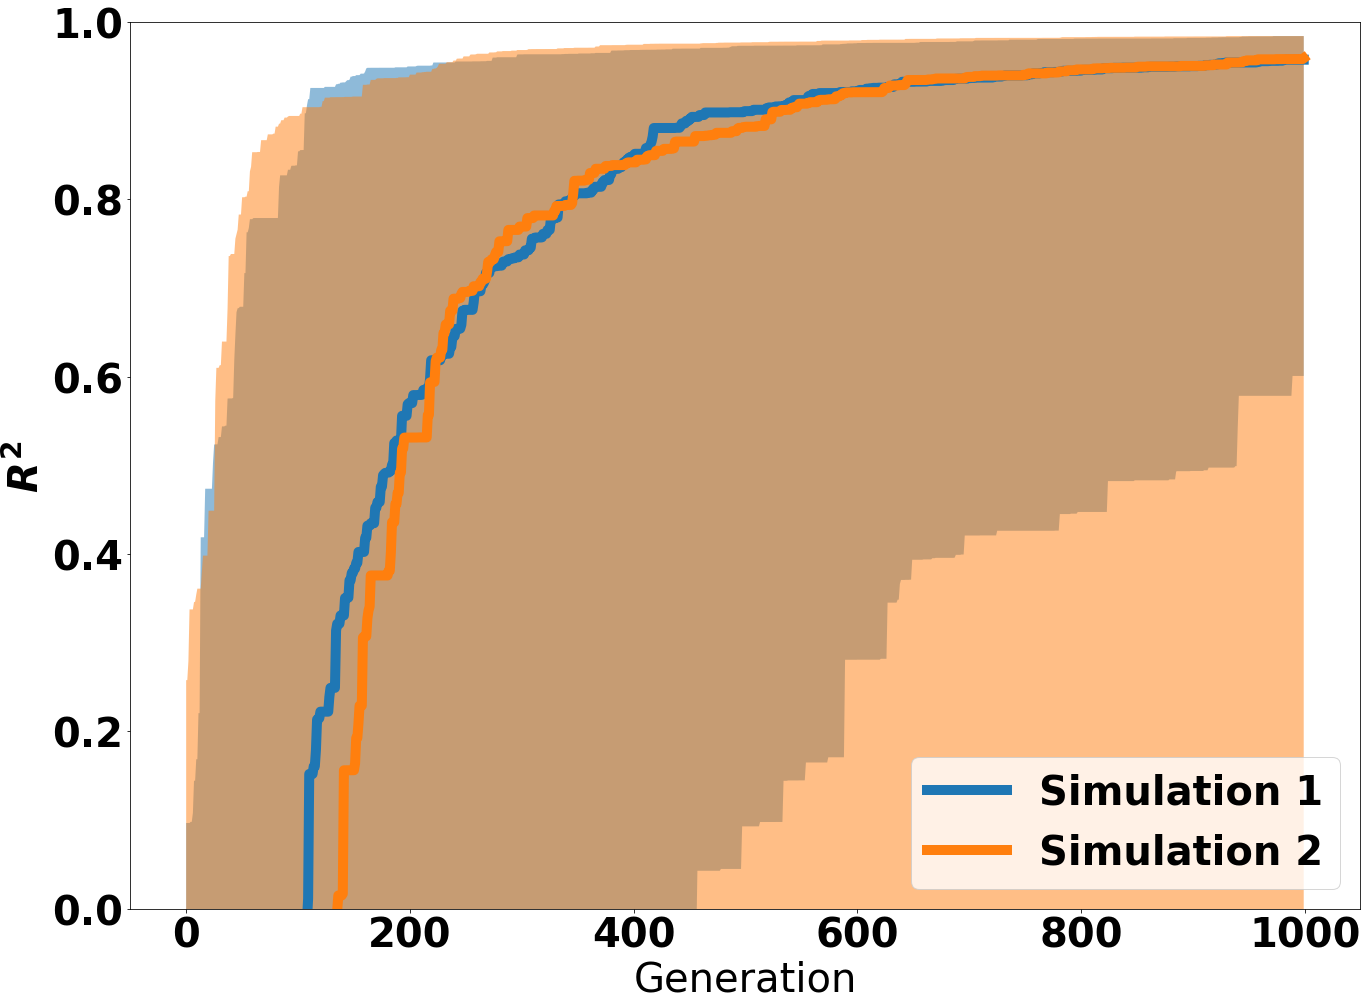

In [57]:
def plot_convergence_evo(distances, maxiter, populations, label = None):
    distance_array = -np.array(distances)
    yp = np.vstack([np.percentile(distance_array[population],[5,50,95]) for population in populations[0:maxiter]])
    plt.plot(np.arange(yp.shape[0]),yp[:,1], label = label,linewidth=10)
    plt.fill_between(np.arange(yp.shape[0]),yp[:,0],yp[:,2],alpha=0.5)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 40}

matplotlib.rc('font', **font)
maxiter = 1000
plt.figure(figsize=(20,15))
for _, entry in evo_model_frame.iterrows():
    scaling_factor = entry["scaling_factor"]
    crossover_prob = entry["crossover_prob"]
    if scaling_factor != 0.5 or crossover_prob != 0.99:
        continue
    simulation = entry["simulation"]
    populations = entry["population"]
    distances = entry["all_distances"]
    plot_convergence_evo(distances,maxiter=1000,populations=populations, label = f'Simulation {simulation + 1}')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Generation')
    plt.ylabel('$R^2$')
    plt.tight_layout()
    plt.legend(loc="lower right")

In [66]:
evo_PCS,evo_EV = load_pickle("../results/crowdingDE/evo_pca.pkl")
evo_combined_df = load_pickle("../results/crowdingDE/evo_combined_df.pkl")
frame_ID = evo_combined_df["frame_ID"].to_numpy()
particle_id = evo_combined_df["particle_ID"].to_numpy()
scaling_factor_values = np.unique(evo_model_frame["scaling_factor"])
crossover_prob_values = np.unique(evo_model_frame["crossover_prob"])
lookup_frame = evo_model_frame.set_index(keys=["scaling_factor","crossover_prob","simulation"])
lookup_frame["frame_ID"] = range(lookup_frame.shape[0])

In [69]:
plt.clf()

<Figure size 432x288 with 0 Axes>

(655,)
(1220,)


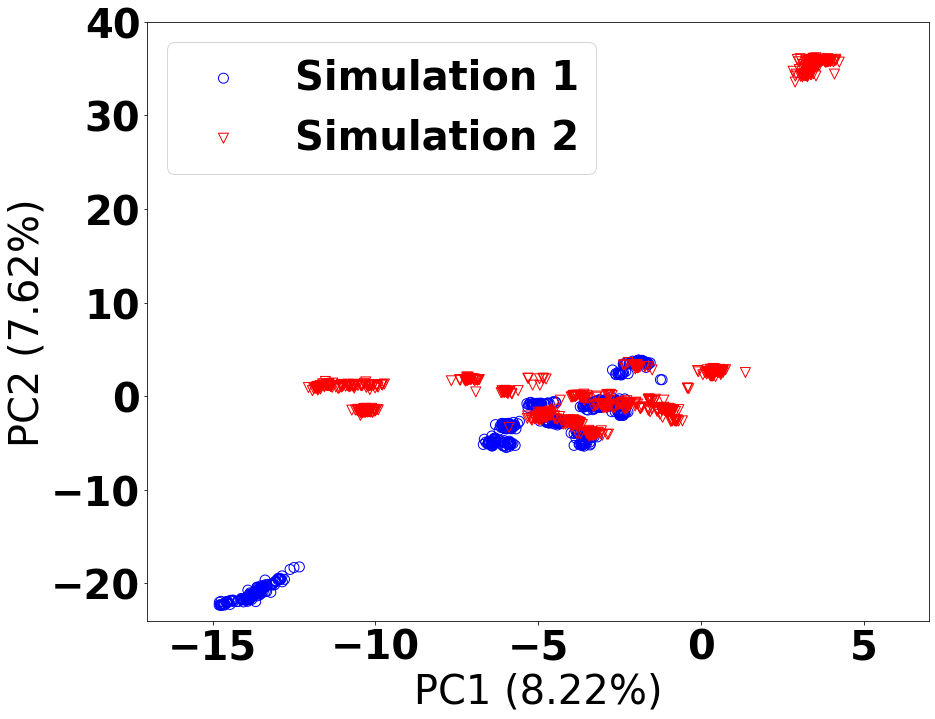

In [76]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 40}

matplotlib.rc('font', **font)
maxiter = 1000


marker_dict = {0: 'o', 1: "v"} # Based on simulation number
scaling_factor = 0.5
crossover_prob = 0.99
plt.figure(figsize=(14,11))
for simulation in range(2):
    frame_to_choose = lookup_frame.loc[(scaling_factor,crossover_prob,simulation)]
    this_frame_ID = frame_to_choose["frame_ID"]
    label_idxs = np.flatnonzero(frame_ID == this_frame_ID)
    this_idxs = label_idxs
    marker = marker_dict[simulation]
    print(label_idxs.shape)
    plt.scatter(evo_PCS[this_idxs,0],evo_PCS[this_idxs, 1],edgecolors=["blue","red"][simulation],
                marker=marker,facecolors='none',s=100,label=f"Simulation {simulation+1}")
    plt.xlabel('PC1 ({:.2f}%)'.format(evo_EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(evo_EV[1]*100))
    plt.xticks(np.arange(-15,20,5))
    plt.yticks(np.arange(-20,60,10))
    plt.xlim((-17,7))
    plt.ylim((-24,40))
    plt.tight_layout()
    colors = ['#1f78b4', 'grey', '#fc8d59']

plt.legend(loc="upper left")

In [84]:
fva_res = load_pickle("../results/crowdingDE/evo_fva.pkl")
def aggregate_fva_results(result_df,simulation_attributes):
    flattened_df_list = []
    for _, row in result_df.drop(columns=["particle"]).iterrows():
        raw_df = row["fva_res"]
        df = raw_df
        for attribute in simulation_attributes:
            df[attribute] = row[attribute]
        flattened_df_list.append(df)

    combined_fva_frame = (
        pd.concat(flattened_df_list).
        assign(range= lambda df: df["maximum"] - df["minimum"],
                                                            midpoint= lambda df: (df["maximum"] + df["minimum"]) / 2).
        drop(columns=["minimum", "maximum"])
            )
    simulation_attributes.extend(["condition","reaction","T"])
    aggregated_fva_res = (
        combined_fva_frame.replace([np.inf, -np.inf],np.nan).
        dropna(how="all").
        groupby(simulation_attributes).
        agg(["mean","min","max","std","count"])
                        )
    return aggregated_fva_res

'r_0961No1' # Pyruvate dehydrogenase
['r_0959No1','r_0959No2','r_0959No3'] # Pyruvate decarboxylase
'r_0450No1' # Fructose-bisphosphate aldolase
'r_0438No1'# Ferrocytochrome-c:oxygen oxidoreductase
'r_0917No1' # Phosphoserine phosphatase
'r_0997No1' # Shikimate kinase
'r_2111' # Growth



signature_reactions = {'FBA': 'r_0450No1', 'SHK': 'r_0997No1',}
signature_full_name = {'PDH': 'Pyruvate dehydrogenase', 'FBA': 'Fructose-bisphosphate aldolase', 'FCO': 'Ferrocytochrome-c:oxygen oxidoreductase',
                       'PSP': 'Phosphoserine phosphatase', 'SHK': 'Shikimate kinase', 'GRW': "Growth"}

In [85]:
aggregated_fva_res = aggregate_fva_results(fva_res, ["simulation"])
aggregated_fva_res.reset_index(inplace=True)

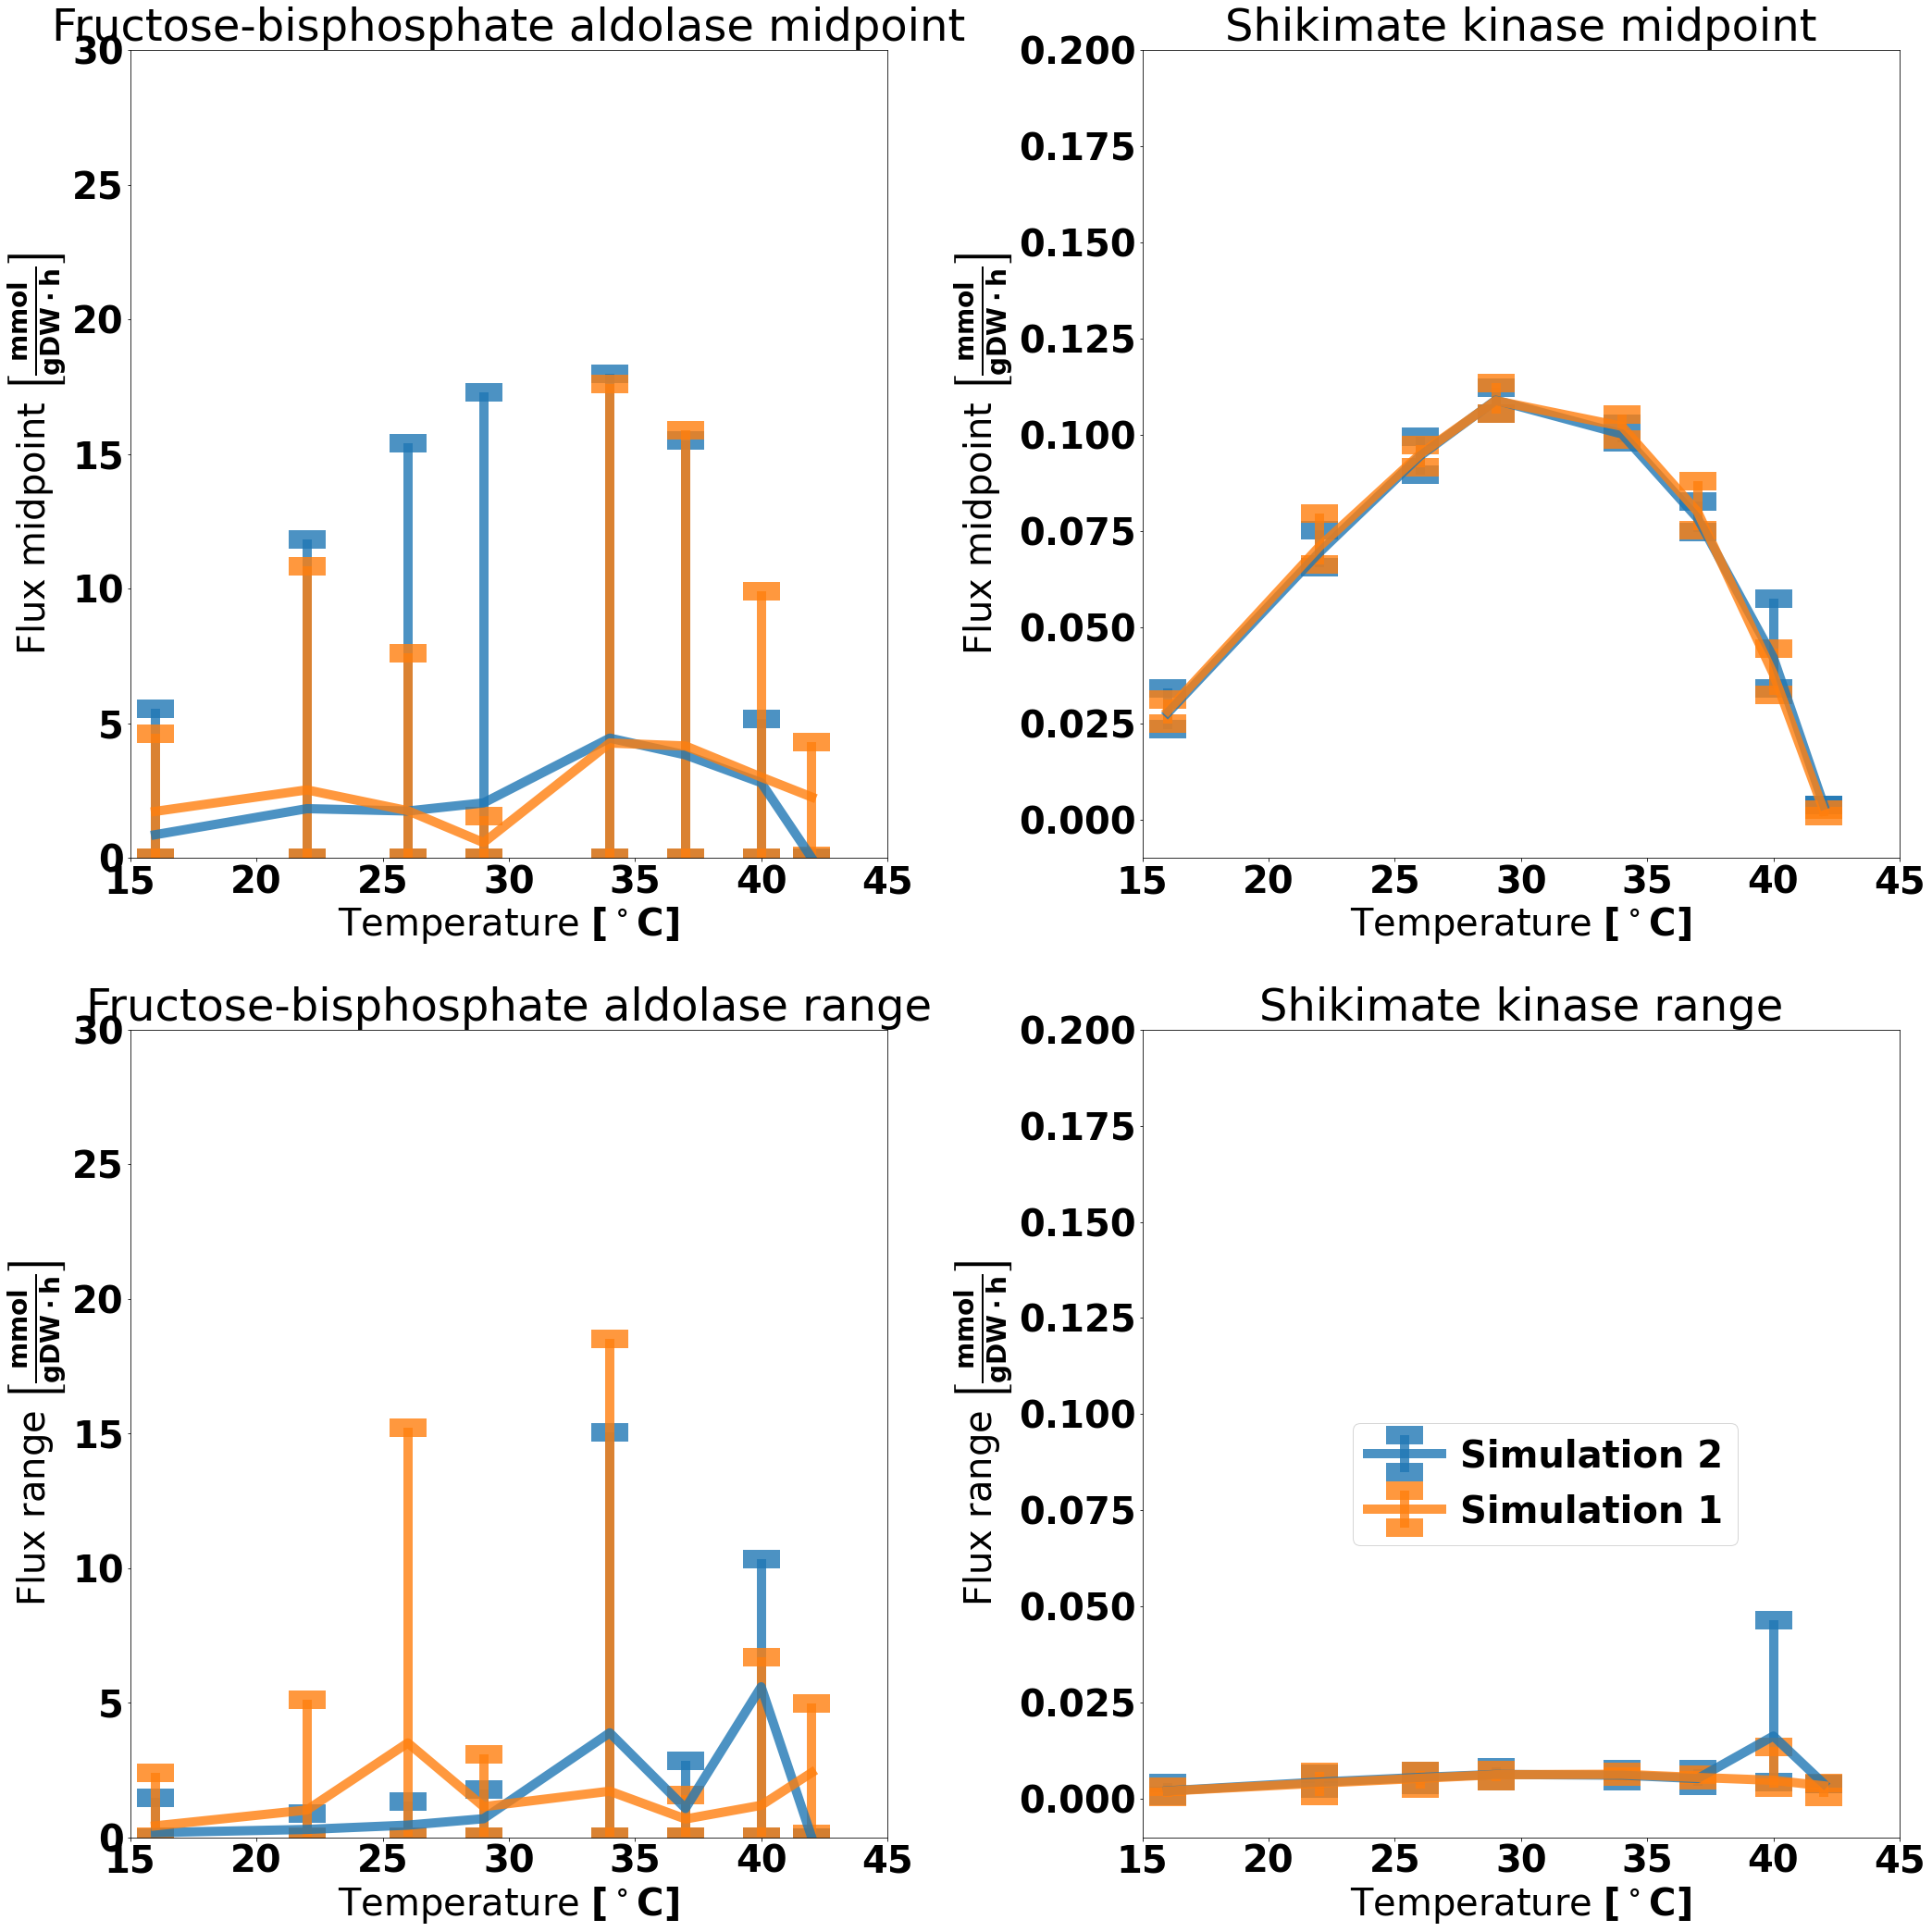

In [99]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 40}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(simulation,reaction, what, linestyle,condition="aerobic",label=None):
    if label is None:
        label = f"Simulation {simulation+1}"
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["simulation"] == simulation) & (df["reaction"] == react_id) & (df["condition"] == condition)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=15,capsize=20,capthick=20,linestyle=linestyle, label=label,linewidth=10,alpha=0.8)
    return
    
plt.figure(figsize=(30,30))
nrows = 2
ncols = 2
i = 1
subplot_order = {1: 1, 2: 3, 3: 2, 4:4}
ymaxs = {"PDH": 1, "FBA": 30, "FCO": 10, "PSP": 0.5, "SHK": 0.2, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        plt.subplot(2,2,subplot_order[i])
        extract_results_and_plot(simulation=1,reaction=reaction, what=what, linestyle="solid")
        extract_results_and_plot(simulation=0,reaction=reaction, what=what, linestyle="solid")
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 4:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.2),ncol=1,handletextpad=0.5)
# plt.savefig("../figures/evo_aerobic_fva.pdf")